# Determining the maximum distance threshold for perfect table recall

The purpose of this notebook is to calculate the minumum distance between decomposition phrases of a natural language question and natural descriptions of database tables. This tells us what (if any) threshold would most likely be required for a semantic search / vector search-based filter to achieve perfect recall required for correct NL-to-SQL inference. We should also be able to see how much precision is possible with that threshold.

In [17]:
import os
import torch
import gc
import time
from tqdm import tqdm
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

In [50]:
os.chdir("/data/kluoma/skalpel-subsetting-evaluation/src")
from NlSqlBenchmark.NlSqlBenchmark import NlSqlBenchmark, BenchmarkQuestion
from NlSqlBenchmark.NlSqlBenchmarkFactory import NlSqlBenchmarkFactory
from NlSqlBenchmark.SchemaObjects import (
    Schema, SchemaTable, TableColumn
)
from SchemaSubsetter.Perfect.PerfectSchemaSubsetter import PerfectSchemaSubsetter
from SchemaSubsetter.SkalpelSubsetter import SkalpelSubsetter
from BenchmarkEmbedding.BenchmarkEmbedding import BenchmarkEmbedding, WordIdentifierDistance

In [51]:
os.chdir("/data/kluoma/skalpel-subsetting-evaluation/")

In [4]:
perf_subsetter = PerfectSchemaSubsetter()
bm_fact = NlSqlBenchmarkFactory()


# Calculating Distance

### Question <-> Table Names

In [53]:
results_dict = {
    "benchmark": [],
    "database": [],
    "question_number": [],
    "table": [],
    "in_subset": [],
    "distance": []
}
for benchmark_name in bm_fact.benchmark_register:
    benchmark = bm_fact.build_benchmark(benchmark_name)
    bm_embed = BenchmarkEmbedding(benchmark_name=benchmark_name, db_host_profile=None, db_host="cdas2", cuda_device=0)
    for question in tqdm(benchmark, desc=benchmark_name):
        if (
            benchmark_name in results_dict["benchmark"]
            and question.schema.database in results_dict["database"]
            and question.question_number in results_dict["question_number"]
        ):
            continue
        perfect_subset = perf_subsetter.get_schema_subset(benchmark_question=question)
        vect_search_results = bm_embed.get_identifiers_from_semantic_search(
            search_word=question.question,
            database_name=question.schema.database,
            distance_threshold=1.0,
        )
        table_distances = {wid.database_identifier: wid.distance for wid in vect_search_results.tables}
        for table in table_distances.keys():
            results_dict["benchmark"].append(benchmark.name)
            results_dict["database"].append(question.schema.database)
            results_dict["question_number"].append(question.question_number)
            results_dict["table"].append(table)
            results_dict["in_subset"].append(
                perfect_subset.table_exists(table)
            )
            results_dict["distance"].append(table_distances[table])
        # break
    del bm_embed
    gc.collect()
    torch.cuda.empty_cache()
    # break
    time.sleep(10)

bird: 100%|██████████| 1534/1534 [00:44<00:00, 34.22it/s] 
abstract: 0it [00:00, ?it/s]


In [54]:
if True:
    question_tablenames_df = pd.DataFrame(results_dict)
    question_tablenames_df.to_excel("./subsetting_results/perfect_recall_distance/perfect_recall_distances_question_tablenames.xlsx")
else:
    question_tablenames_df = pd.read_excel("./subsetting_results/perfect_recall_distance/perfect_recall_distances_question_tablenames.xlsx")

### Question <-> Table Descriptions

In [57]:
results_dict = {
    "benchmark": [],
    "database": [],
    "question_number": [],
    "table": [],
    "in_subset": [],
    "distance": []
}
for benchmark_name in bm_fact.benchmark_register:
    benchmark = bm_fact.build_benchmark(benchmark_name)
    skalpel = SkalpelSubsetter(
        benchmark=bm_fact.build_benchmark(benchmark_name),
        model="gpt-4.1-nano"
        )
    for question in tqdm(benchmark, desc=benchmark_name):
        if (
            benchmark_name in results_dict["benchmark"]
            and question.schema.database in results_dict["database"]
            and question.question_number in results_dict["question_number"]
        ):
            continue
        perfect_subset = perf_subsetter.get_schema_subset(benchmark_question=question)
        vect_search_results = skalpel.vector_search.get_similar_table_descriptions_from_db(
            db_name=question.schema.database,
            input_sequence=question.question,
            distance_threshold=1.0,
            schema_proportion=1.0
        )
        table_distances = {wid.database_identifier: wid.distance for wid in vect_search_results.tables}
        for table in table_distances.keys():
            results_dict["benchmark"].append(benchmark.name)
            results_dict["database"].append(question.schema.database)
            results_dict["question_number"].append(question.question_number)
            results_dict["table"].append(table)
            results_dict["in_subset"].append(
                perfect_subset.table_exists(table)
            )
            results_dict["distance"].append(table_distances[table])
        # break
    del skalpel
    gc.collect()
    torch.cuda.empty_cache()
    # break
    time.sleep(10)

bird: 100%|██████████| 1534/1534 [00:44<00:00, 34.36it/s] 
abstract: 0it [00:00, ?it/s]


In [58]:
if True:
    question_tabledescriptions_df = pd.DataFrame(results_dict)
    question_tabledescriptions_df.to_excel("./subsetting_results/perfect_recall_distance/perfect_recall_distances_question_tabledescriptions.xlsx")
else:
    question_tablenames_df = pd.read_excel("./subsetting_results/perfect_recall_distance/perfect_recall_distances_question_tabledescriptions.xlsx")

### Question Decomposition <-> Table Names

In [60]:
results_dict = {
    "benchmark": [],
    "database": [],
    "question_number": [],
    "table": [],
    "in_subset": [],
    "distance": []
}
for benchmark_name in bm_fact.benchmark_register:
    benchmark = bm_fact.build_benchmark(benchmark_name)
    skalpel = SkalpelSubsetter(
        benchmark=bm_fact.build_benchmark(benchmark_name),
        model="gpt-4.1-nano"
        )
    bm_embed = BenchmarkEmbedding(benchmark_name=benchmark_name, db_host_profile=None, db_host="cdas2", cuda_device=0)
    for question in tqdm(benchmark, desc=benchmark_name):
        if (
            benchmark_name in results_dict["benchmark"]
            and question.schema.database in results_dict["database"]
            and question.question_number in results_dict["question_number"]
        ):
            continue
        perfect_subset = perf_subsetter.get_schema_subset(benchmark_question=question)
        decomposed_question = skalpel._decompose_question(benchmark_question=question)
        table_distances = {}
        for dcq in decomposed_question[0]:
            vect_search_results = bm_embed.get_identifiers_from_semantic_search(
                search_word=dcq,
                database_name=question.schema.database,
                distance_threshold=1.0
            )
            for wid in vect_search_results.tables:
                if wid.database_identifier not in table_distances.keys():
                    table_distances[wid.database_identifier] = wid.distance
                else:
                    table_distances[wid.database_identifier] = max(wid.distance, table_distances[wid.database_identifier])
        for table in table_distances.keys():
            results_dict["benchmark"].append(benchmark.name)
            results_dict["database"].append(question.schema.database)
            results_dict["question_number"].append(question.question_number)
            results_dict["table"].append(table)
            results_dict["in_subset"].append(
                perfect_subset.table_exists(table)
            )
            results_dict["distance"].append(table_distances[table])
        # break
    del skalpel
    gc.collect()
    torch.cuda.empty_cache()
    # break
    time.sleep(10)

bird: 100%|██████████| 1534/1534 [06:40<00:00,  3.83it/s] 
abstract: 0it [00:00, ?it/s]


In [61]:
if True:
    questiondecomp_tablenames_df = pd.DataFrame(results_dict)
    questiondecomp_tablenames_df.to_excel("./subsetting_results/perfect_recall_distance/perfect_recall_distances_questiondecomp_tablenames.xlsx")
else:
    question_tablenames_df = pd.read_excel("./subsetting_results/perfect_recall_distance/perfect_recall_distances_questiondecomp_tablenames.xlsx")

### Question Decomposition <-> Table Descriptions

In [11]:
results_dict = {
    "benchmark": [],
    "database": [],
    "question_number": [],
    "table": [],
    "in_subset": [],
    "distance": []
}
for benchmark_name in bm_fact.benchmark_register:
    benchmark = bm_fact.build_benchmark(benchmark_name)
    skalpel = SkalpelSubsetter(
        benchmark=bm_fact.build_benchmark(benchmark_name),
        model="gpt-4.1-nano"
        )
    for question in tqdm(benchmark, desc=benchmark_name):
        if (
            benchmark_name in results_dict["benchmark"]
            and question.schema.database in results_dict["database"]
            and question.question_number in results_dict["question_number"]
        ):
            continue
        perfect_subset = perf_subsetter.get_schema_subset(benchmark_question=question)
        table_distances = skalpel._do_vector_search_table_retrieval(
            benchmark_question=question,
            distance_threshold=1.0,
            schema_proportion=1.0,
            chunk_level="whole"
        )
        for table in table_distances[0].keys():
            results_dict["benchmark"].append(benchmark.name)
            results_dict["database"].append(question.schema.database)
            results_dict["question_number"].append(question.question_number)
            results_dict["table"].append(table)
            results_dict["in_subset"].append(
                perfect_subset.table_exists(table)
            )
            results_dict["distance"].append(table_distances[0][table])
        # break
    del skalpel
    gc.collect()
    torch.cuda.empty_cache()
    # break
    time.sleep(10)

snails:  52%|█████▏    | 264/503 [05:01<15:16,  3.84s/it]

Attempting to repair LLM-generated JSON [
    "A vehicle is a means of transportation, typically a motor vehicle such as a car, truck, or bus.",
    "A pillar refers to a structural support in a vehicle's body, specifically the A pillar which is the frontmost vertical support on either side of the windshield."
    "Damage indicates physical harm or impairment to the vehicle's structure."
] Expecting ',' delimiter: line 4 column 5 (char 276)


spider2:  71%|███████   | 156/221 [09:24<07:56,  7.33s/it]

Attempting to repair LLM-generated JSON [
    "TCGA-BRCA cohort is a group of breast cancer patients within The Cancer Genome Atlas database.",
    "Patients are individuals diagnosed with breast cancer.",
    "Patients' age at diagnosis is the age when they were diagnosed with cancer.",
    "Age 80 years old or younger refers to patients aged 80 or less at diagnosis.",
    "Pathological stage indicates the extent of cancer based on tissue examination, with stages I, II, and IIA representing specific severity levels.",
    "Stage I is an early stage of cancer with limited spread.",
    "Stage II is a more advanced stage with increased spread but still localized.",
    "Stage IIA is a subcategory of stage II with specific tumor and spread characteristics.",
    "Calculate the t-statistic is a statistical operation to measure the significance of a correlation.",
    "Pearson correlation is a measure of linear correlation between two variables.",
    "Log10-transformed average RNA-Seq exp

bird: 100%|██████████| 1534/1534 [06:47<00:00,  3.76it/s] 
abstract: 0it [00:00, ?it/s]


In [15]:
results_dict

{'benchmark': ['snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  'snails',
  '

In [ ]:
if False:
    decomp_table_desc_results_df = pd.DataFrame(results_dict)
    decomp_table_desc_results_df.to_excel("./subsetting_results/perfect_recall_distance/perfect_recall_distances_question_decomposition_all_tables.xlsx")
else:
    decomp_table_desc_results_df = pd.read_excel(
        "./subsetting_results/perfect_recall_distance/perfect_recall_distances_question_decomposition_all_tables.xlsx"
        )

# Evaluate Distance Threshold Gradient

In [6]:
eval_df = decomp_table_desc_results_df.copy()

In [7]:
def get_subset_at_threshold(benchmark: str, question: BenchmarkQuestion, dist_df: pd.DataFrame, threshold: float) -> pd.DataFrame:
    subset_df = dist_df.query(
        f"benchmark=='{benchmark}' and database=='{question.schema.database}' and question_number=={question.question_number}"
        ).copy()
    subset_df["below_threshold"] = subset_df.distance.apply(lambda x: x <= threshold)
    return subset_df

In [8]:
def calculate_question_performance(subset_df: pd.DataFrame) -> dict[str, float]:
    predicted_tables = set(subset_df.query("below_threshold")["table"].to_list())
    gold_tables = set(subset_df.query("in_subset")["table"].to_list())
    all_tables = set(subset_df["table"].to_list())
    results_dict = {}
    results_dict["recall"] = len(gold_tables.intersection(predicted_tables)) / max(len(gold_tables), 1)
    results_dict["precision"] = len(gold_tables.intersection(predicted_tables)) / max(len(predicted_tables), 1)
    f1_denom = results_dict["recall"] + results_dict["precision"]
    if f1_denom > 0:
        results_dict["f1"] = 2*(results_dict["recall"]*results_dict["precision"])/f1_denom
    else:
        results_dict["f1"] = 0
    results_dict["schema_proportion"] = (len(gold_tables.union(predicted_tables))) / len(all_tables)
    return results_dict

## Coarse Gradient

In [65]:
gradient_performance = {
    "benchmark": [],
    "database": [],
    "question_number": [],
    "threshold": [],
    "recall": [],
    "precision": [],
    "f1": [],
    "schema_proportion": []
}
for i in range(10, 0, -1):
    threshold = i / 10
    print("Calculating at threshold:", threshold)
    for benchmark_name in bm_fact.benchmark_register:
        benchmark = bm_fact.build_benchmark(benchmark_name)
        for question in tqdm(benchmark, desc=benchmark_name):
            subset_df = get_subset_at_threshold(
                benchmark=benchmark_name,
                question=question,
                dist_df=eval_df,
                threshold=threshold
                )
            if subset_df.shape[0] == 0:
                continue
            question_performance = calculate_question_performance(subset_df=subset_df)
            gradient_performance["benchmark"].append(benchmark_name)
            gradient_performance["database"].append(question.schema.database)
            gradient_performance["question_number"].append(question.question_number)
            gradient_performance["threshold"].append(threshold)
            gradient_performance["recall"].append(question_performance["recall"])
            gradient_performance["precision"].append(question_performance["precision"])
            gradient_performance["f1"].append(question_performance["f1"])
            gradient_performance["schema_proportion"].append(question_performance["schema_proportion"])
gradient_performance_df = pd.DataFrame(gradient_performance)

Calculating at threshold: 1.0


bird: 100%|██████████| 1534/1534 [00:03<00:00, 432.03it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.9


bird: 100%|██████████| 1534/1534 [00:03<00:00, 439.27it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.8


bird: 100%|██████████| 1534/1534 [00:03<00:00, 439.97it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.7


bird: 100%|██████████| 1534/1534 [00:03<00:00, 434.58it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.6


bird: 100%|██████████| 1534/1534 [00:03<00:00, 440.41it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.5


bird: 100%|██████████| 1534/1534 [00:03<00:00, 440.62it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.4


bird: 100%|██████████| 1534/1534 [00:03<00:00, 438.69it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.3


bird: 100%|██████████| 1534/1534 [00:03<00:00, 438.92it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.2


bird: 100%|██████████| 1534/1534 [00:03<00:00, 436.33it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.1


bird: 100%|██████████| 1534/1534 [00:03<00:00, 437.84it/s]
abstract: 0it [00:00, ?it/s]


In [66]:
gradient_performance_df

,benchmark,database,question_number,threshold,recall,precision,f1,schema_proportion
0,snails,ASIS_20161108_HerpInv_Database,0,1.0,1.0,0.027778,0.054054,1.000000
1,snails,ASIS_20161108_HerpInv_Database,1,1.0,1.0,0.027778,0.054054,1.000000
2,snails,ASIS_20161108_HerpInv_Database,2,1.0,1.0,0.027778,0.054054,1.000000
3,snails,ASIS_20161108_HerpInv_Database,3,1.0,1.0,0.055556,0.105263,1.000000
4,snails,ASIS_20161108_HerpInv_Database,4,1.0,1.0,0.027778,0.054054,1.000000
...,...,...,...,...,...,...,...,...
3145,bird,thrombosis_prediction,0,0.1,0.0,0.000000,0.000000,0.333333
3146,bird,toxicology,0,0.1,0.0,0.000000,0.000000,0.250000
3147,bird,student_club,0,0.1,0.0,0.000000,0.000000,0.250000
3148,bird,superhero,0,0.1,0.0,0.000000,0.000000,0.300000


<Axes: xlabel='threshold', ylabel='Score'>

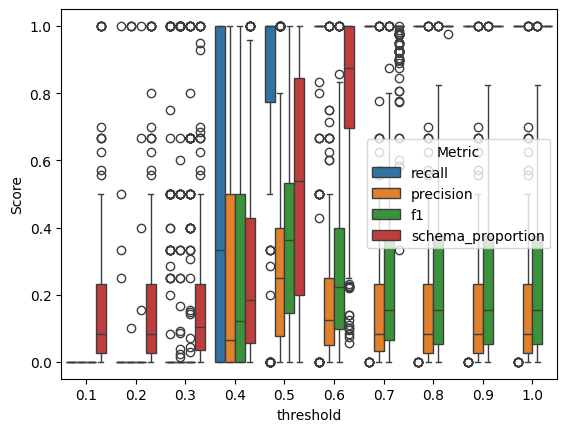

In [67]:
sns.boxplot(
    data=gradient_performance_df.melt(
        id_vars=["benchmark", "database", "question_number", "threshold"],
        value_vars=["recall", "precision", "f1", "schema_proportion"],
        value_name="Score",
        var_name="Metric"
    ),
    x="threshold",
    y="Score",
    hue="Metric"
)

## Fine Gradient Between 0.6 and 0.4

In [25]:
fine_gradient_performance = {
    "benchmark": [],
    "database": [],
    "question_number": [],
    "threshold": [],
    "recall": [],
    "precision": [],
    "f1": [],
    "schema_proportion": []
}
for i in range(1000, 0, -25):
    threshold = i / 1000
    print("Calculating at threshold:", threshold)
    for benchmark_name in bm_fact.benchmark_register:
        benchmark = bm_fact.build_benchmark(benchmark_name)
        for question in tqdm(benchmark, desc=benchmark_name):
            subset_df = get_subset_at_threshold(
                benchmark=benchmark_name,
                question=question,
                dist_df=eval_df,
                threshold=threshold
                )
            if subset_df.shape[0] == 0:
                continue
            question_performance = calculate_question_performance(subset_df=subset_df)
            fine_gradient_performance["benchmark"].append(benchmark_name)
            fine_gradient_performance["database"].append(question.schema.database)
            fine_gradient_performance["question_number"].append(question.question_number)
            fine_gradient_performance["threshold"].append(threshold)
            fine_gradient_performance["recall"].append(question_performance["recall"])
            fine_gradient_performance["precision"].append(question_performance["precision"])
            fine_gradient_performance["f1"].append(question_performance["f1"])
            fine_gradient_performance["schema_proportion"].append(question_performance["schema_proportion"])
fine_gradient_performance_df = pd.DataFrame(fine_gradient_performance)

Calculating at threshold: 1.0


bird: 100%|██████████| 1534/1534 [00:03<00:00, 420.80it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.975


bird: 100%|██████████| 1534/1534 [00:04<00:00, 382.58it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.95


bird: 100%|██████████| 1534/1534 [00:03<00:00, 417.92it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.925


bird: 100%|██████████| 1534/1534 [00:03<00:00, 418.55it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.9


bird: 100%|██████████| 1534/1534 [00:03<00:00, 418.78it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.875


bird: 100%|██████████| 1534/1534 [00:03<00:00, 420.01it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.85


bird: 100%|██████████| 1534/1534 [00:03<00:00, 417.23it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.825


bird: 100%|██████████| 1534/1534 [00:03<00:00, 419.89it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.8


bird: 100%|██████████| 1534/1534 [00:03<00:00, 417.78it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.775


bird: 100%|██████████| 1534/1534 [00:03<00:00, 416.84it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.75


bird: 100%|██████████| 1534/1534 [00:03<00:00, 415.78it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.725


bird: 100%|██████████| 1534/1534 [00:03<00:00, 416.14it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.7


bird: 100%|██████████| 1534/1534 [00:03<00:00, 413.93it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.675


bird: 100%|██████████| 1534/1534 [00:03<00:00, 413.97it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.65


bird: 100%|██████████| 1534/1534 [00:03<00:00, 416.66it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.625


bird: 100%|██████████| 1534/1534 [00:03<00:00, 417.84it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.6


bird: 100%|██████████| 1534/1534 [00:03<00:00, 418.75it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.575


bird: 100%|██████████| 1534/1534 [00:03<00:00, 417.43it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.55


bird: 100%|██████████| 1534/1534 [00:03<00:00, 420.47it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.525


bird: 100%|██████████| 1534/1534 [00:03<00:00, 419.09it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.5


bird: 100%|██████████| 1534/1534 [00:03<00:00, 418.08it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.475


bird: 100%|██████████| 1534/1534 [00:03<00:00, 417.97it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.45


bird: 100%|██████████| 1534/1534 [00:03<00:00, 417.78it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.425


bird: 100%|██████████| 1534/1534 [00:03<00:00, 418.85it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.4


bird: 100%|██████████| 1534/1534 [00:03<00:00, 414.26it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.375


bird: 100%|██████████| 1534/1534 [00:03<00:00, 415.02it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.35


bird: 100%|██████████| 1534/1534 [00:03<00:00, 412.98it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.325


bird: 100%|██████████| 1534/1534 [00:03<00:00, 412.93it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.3


bird: 100%|██████████| 1534/1534 [00:03<00:00, 415.51it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.275


bird: 100%|██████████| 1534/1534 [00:03<00:00, 418.72it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.25


bird: 100%|██████████| 1534/1534 [00:03<00:00, 418.28it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.225


bird: 100%|██████████| 1534/1534 [00:03<00:00, 419.64it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.2


bird: 100%|██████████| 1534/1534 [00:03<00:00, 418.13it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.175


bird: 100%|██████████| 1534/1534 [00:03<00:00, 415.64it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.15


bird: 100%|██████████| 1534/1534 [00:03<00:00, 413.42it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.125


bird: 100%|██████████| 1534/1534 [00:03<00:00, 415.04it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.1


bird: 100%|██████████| 1534/1534 [00:03<00:00, 415.38it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.075


bird: 100%|██████████| 1534/1534 [00:03<00:00, 418.36it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.05


bird: 100%|██████████| 1534/1534 [00:03<00:00, 416.17it/s]
abstract: 0it [00:00, ?it/s]


Calculating at threshold: 0.025


bird: 100%|██████████| 1534/1534 [00:03<00:00, 416.89it/s]
abstract: 0it [00:00, ?it/s]


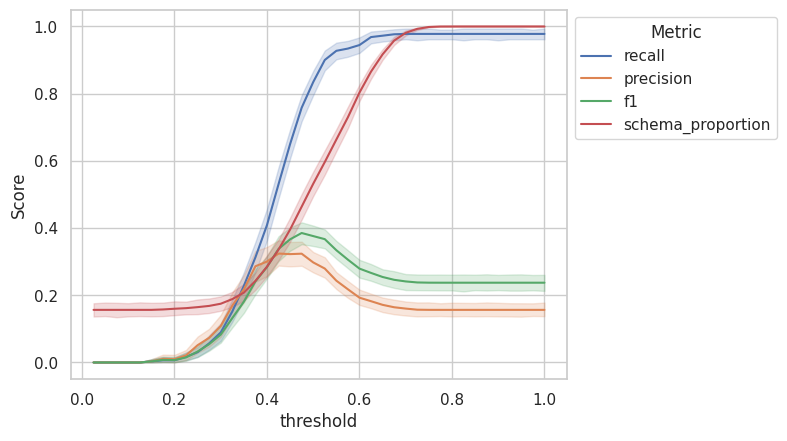

In [26]:
g = sns.lineplot(
    data=fine_gradient_performance_df.melt(
        id_vars=["benchmark", "database", "question_number", "threshold"],
        value_vars=["recall", "precision", "f1", "schema_proportion"],
        value_name="Score",
        var_name="Metric"
    ),
    x="threshold",
    y="Score",
    hue="Metric"
)

sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
